In [1]:

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import mccd
from astropy.io import fits

%pylab inline

print(tf.__version__)





runstats and/or skimage could not be imported because not installed
Populating the interactive namespace from numpy and matplotlib
2.4.4


In [ ]:


def eigenPSF_data_gen(
    data, 
    snr_range=[1e-3, 50],
    img_shape=(51, 51),
    batch_size=16,
    win_rad=14,
    n_shuffle=50,
    noise_estimator=True,
    enhance_noise=False,
):
    """ Dataset generator of eigen-PSFs.

    On-the-fly addition of noise following a SNR distribution.
    We also calculate the noise std.

    Parameters
    ----------
    data: np.ndarray [batch, im_x, im_y]
        Input images.
    snr_range: numpy.ndarray
        Min and max snr for noise addition.
    img_shape: tuple
        Image dimensions
    batch_size: int
        Batch size
    win_rad: int
        Window radius in pixels for noise estimation.
    n_shuffle: int
        Number of batchs used to shuffle.
    noise_estimator: bool
        If the noise estimation is returned from the `add_noise_function`
    enhance_noise: bool
        If True the noise distribution will be skewed for more noisy values
        insterad of being flat in the SNR range.

    """
    # Verify the eigenPSFs are positive
    multiple = np.array([np.sum(im)>0 for im in data]) * 2. - 1.
    data *= multiple.reshape((-1, 1, 1))
    # Verify consistency
    if (data.shape[1] != img_shape[0]) or (data.shape[2] != img_shape[1]):
        raise ValueError
        
        
        
    # Create 
        
    # Expand last dimension
    data = np.reshape(data, (data.shape[0], img_shape[0], img_shape[1], 1))
    # Shuffle data
    np.random.shuffle(data)

    # Init dataset from file
    ds = tf.data.Dataset.from_tensor_slices(data)
    # Cast SNR range 
    tf_snr_range = tf.cast(snr_range, dtype=tf.float64)
    # Create window for noise estimation
    tf_window = tf.cast(calculate_window(
        im_shape=(img_shape[0], img_shape[1]), win_rad=win_rad),
        dtype=tf.bool)
    tf_window = tf.reshape(tf_window, (img_shape[0], img_shape[1], 1))

    # Normalise
    image_noise_ds = ds.map(normalise, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Apply noise and estimate noise std
    image_noisy_ds = image_noise_ds.map(
        lambda x: (add_noise_function(
            x,
            tf_snr_range,
            tf_window,
            noise_estimator=noise_estimator,
            enhance_noise=enhance_noise
        ), x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    # Shuffle the data
    image_noise_ds = image_noisy_ds.shuffle(buffer_size=n_shuffle*batch_size)
    # Batch after shuffling to get unique batches at each epoch.
    image_noisy_ds = image_noisy_ds.batch(batch_size)
    image_noisy_ds = image_noisy_ds.repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return image_noisy_ds





In [56]:

dataset_path = '/n05data/tliaudat/new_deepmccd/training_realistic_sims/output_mccd/eigenPSF_datasets/local_eigenpsfs.fits'

dataset = fits.open(dataset_path)
dataset[1].data['VIGNETS_NOISELESS'].shape



(280000, 51, 51)

In [58]:
eigen_num = 280000

In [73]:
import itertools
import galsim as gs

In [53]:

# fwhm = np.random.uniform(2.5, 8, 10)
# sigma = np.sqrt(R2/2)
# fwhm_psf = sigma/(2*np.sqrt(2*np.log(2)))

In [91]:
eigen_num = 100

In [92]:

star_ratio = 0.4
_star_num = np.floor(eigen_num * star_ratio).astype(int)
print('_star_num: ', _star_num)

var_num = np.floor(np.power(_star_num, 1/3)).astype(int)
print('var_num: ', var_num)
star_num = var_num**3
print('real star_num: ', var_num**3)


_star_num:  40
var_num:  3
real star_num:  27


In [93]:
e1 = np.linspace(-0.15, 0.15, num=var_num, endpoint=True)
e2 = np.linspace(-0.15, 0.15, num=var_num, endpoint=True)
fwhm = np.linspace(0.5, 1.,  num=var_num, endpoint=True)

es = list(itertools.product(*[e1, e2, fwhm]))
e1s = np.array([a for a,b,c in es])
e2s = np.array([b for a,b,c in es]) 
fwhms = np.array([c for a,b,c in es])


In [94]:
fwhms

array([0.5 , 0.75, 1.  , 0.5 , 0.75, 1.  , 0.5 , 0.75, 1.  , 0.5 , 0.75,
       1.  , 0.5 , 0.75, 1.  , 0.5 , 0.75, 1.  , 0.5 , 0.75, 1.  , 0.5 ,
       0.75, 1.  , 0.5 , 0.75, 1.  ])

In [95]:

pix_scale = 0.187
beta_psf = 4.765
psf_flux = 1
image_size = 51


In [96]:

parametric_data = np.zeros((star_num, image_size, image_size))

for it in range(star_num):
    # PSF generation. Define size
    psf = gs.Moffat(fwhm=fwhms[it], beta=beta_psf)
    # Define the Flux
    psf = psf.withFlux(psf_flux)
    # Define the shear
    psf = psf.shear(g1=e1s[it], g2=e2s[it])
    # Draw the PSF on a vignet
    image_epsf = gs.ImageF(image_size, image_size)
    # Define intrapixel shift (uniform distribution in [-0.25,0.25])
    rand_shift = (np.random.rand(2) - 0.5) / 2
    psf.drawImage(image=image_epsf, offset=rand_shift, scale=pix_scale)

    # Save images before adding the noise
    parametric_data[it,:,:] = image_epsf.array


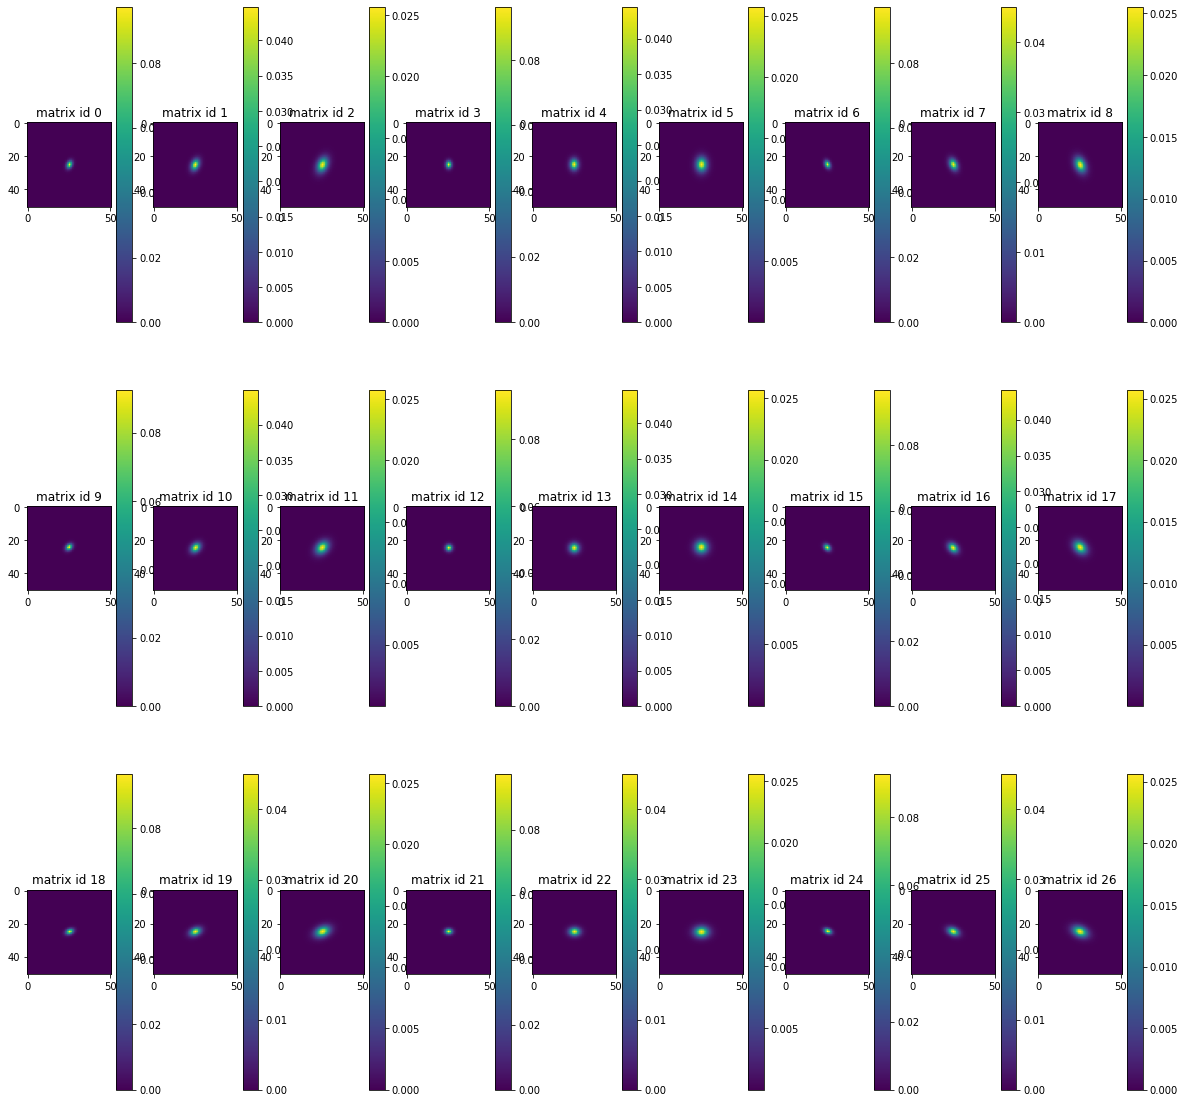

In [97]:

mccd.utils.plot_imgs(parametric_data, cmap = 'viridis', figsize=(20,20))


In [19]:
input_data_dir = '/home/tliaudat/github/aziz_repos/deep_mccd/data/realistic_dataset_input/'

e1_data = np.load(input_data_dir + 'e1_psf.npy', allow_pickle=True)
e2_data = np.load(input_data_dir + 'e2_psf.npy', allow_pickle=True)
size_data = np.load(input_data_dir + 'seeing_distribution.npy', allow_pickle=True)[()]


In [31]:
print('e1:')
print(np.max(e1_data))
print(np.min(e1_data))

print('e2:')
print(np.max(e2_data))
print(np.min(e2_data))

print('fwhm:')
x_in = np.linspace(0.01,.99,50)
print(np.max(size_data.ppf(x_in)))
print(np.min(size_data.ppf(x_in)))


e1:
0.067391843501102
-0.07135929512887557
e2:
0.0438797801589977
-0.052992094464912896
fwhm:
0.9463542982054649
0.528205036279985


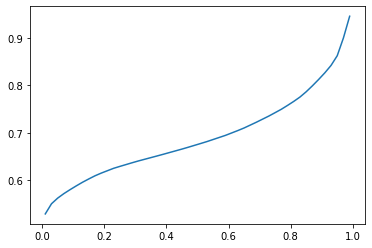

In [30]:
x_in = np.linspace(0.01,.99,50)

plot(x_in, size_data.ppf(x_in))



In [24]:
size_data.ppf(np.random.rand(1))

array([0.68057863])